In [6]:
import os, numpy as np, matplotlib.pyplot as plt, nibabel as nib
from nibabel.testing import data_path
from scipy.interpolate import griddata
from tqdm import tqdm

In [2]:
def show(self, cmap=None):
        cmap = cmap or plt.cm.gray
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.imshow(self, cmap=cmap)
        ax.set_axis_off()
        #plt.show()
        return fig

### Załadowujemy trójwymiarową maskę z pliku .nii

In [175]:
#example_filename = os.path.join(data_path, 'example4d.nii.gz')
#img = nib.load('../../data/001_25_mm.nii')
#img_data = img.get_fdata()[:50,90:100,:50]
#del img
img_mask = nib.load('../../data/001_25_mask.nii')
affine = img_mask.get_affine()
img_mask_data = img_mask.get_fdata()#[:50,90:100,:50]
del img_mask

import copy
img_mask_data_broken_1 = copy.deepcopy(img_mask_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  


In [194]:
np.isfinite(img_mask_data_broken_1[:,92,:]).any()

False

In [188]:
#zepsuc maske
img_mask_data_broken_1.shape
for y in tqdm(range(0,img_mask_data_broken_1.shape[1],5)):
    for i in range(1,4+1):
        img_mask_data_broken_1[:,y+i,:] = np.nan

        

100%|██████████| 81/81 [00:00<00:00, 593.56it/s]


In [177]:
fa = nib.Nifti1Image(img_mask_data_broken_1, affine)
nib.save(fa, 'img_mask_data_broken_1.nii.gz')

In [190]:
x, y, z = np.where(np.isfinite(img_mask_data_broken_1))

In [191]:
np.unique(y)

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385,
       390, 395, 400])

In [195]:
img_mask_data = img_mask_data_broken_1
direction = 1 
filled = np.array([np.isfinite(img_mask_data[:,x,:]).any() \
         for x in range(img_mask_data.shape[direction])])

In [196]:
## zaloadowac maske i obraz
# obejrzec w 3D
# sprobowac 'wymazac' z maski wszystkie maski oprocz co piatej
# sprobowac interpolowac maske na 'wewnetrzne slice'y
filled[0]

True

In [197]:
x = 1

In [ ]:
filled[:x]

In [205]:
np.where(filled[:x])[0].max()

ValueError: zero-size array to reduction operation maximum which has no identity

read image | denoised image
- | - 
{{x = show(img_data[:,9,:]) }}| {{y = show(img_mask_data[:,9,:])}}


In [15]:
def prawidlowa_interpolacja_3D(img_mask_data, step=2):
    x_max, y_max, z_max = img_mask_data.shape
    grid_x, grid_y, grid_z = np.mgrid[0:x_max:1, 0:y_max:1,0:z_max:1]
    #points = np.random.rand(1000, 2)
    point_list = []
    for i in tqdm(range(x_max)):
        for j in range(0,y_max,2):
            for k in range(img_mask_data.shape[2]):
                point_list.append([i,j,k])
    points = np.array(point_list)
    values = img_mask_data[points[:,0],points[:,1],points[:,2]]
    grid_z2 = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')
    #values = img_mask_data[points]
    #img_mask_data
    #del point_list
    grid_num = np.nan_to_num(grid_z2)
    show(grid_num[:,1,:])
    return grid_num

In [ ]:
def trying_4D(img):
    data = img.get_fdata()
    hdr = img.header
    hdr.get_xyzt_units()
    raw = hdr.structarr
    raw['xyzt_units']
    img = nib.Nifti1Image(data, np.eye(4))
    img.to_filename(os.path.join('build','test4d.nii.gz'))
    return

### Przystepujemy do mojej uproszczonej liniowej interpolacji



In [50]:
def simple_interpolation(img_mask_data):
    new_imgs = []
    for i in tqdm(range(5, img_mask_data.shape[1],5)):
        base_img1 = img_mask_data[:,i,:]
        base_img0 = img_mask_data[:,i-5,:]
        diff = (base_img1 - base_img0)
        diff_atomic = diff/5.0
        new_imgs.append(base_img0)
        for j in range(1, 5):
            interp = (base_img0 + (diff_atomic*j)).astype(int)
            new_imgs.append(interp)
    for k in range(i,img_mask_data.shape[1]):
        interp = (base_img1 + (diff_atomic*(img_mask_data.shape[1]-i))).astype(int)
        new_imgs.append(np.array(interp))
        
    return np.transpose(np.dstack(new_imgs),(0,2,1))


### Teraz nalezy ocenic blad takiej interpolacji
Ale to zrobimy pozniej.
(img_mask - interp_mask) **2 ( element wise )


### Teraz interpolacja z konturow.

Dla kazdego skrawka w plaszczyznie koronalnej.

img_mask_data[:,y,:]

wizualizujemy to i bierzemy 

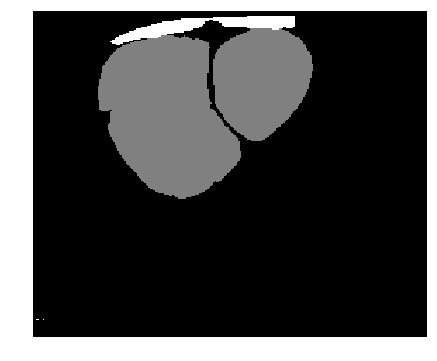

In [55]:
x = show(img_mask_data[:,93,:])

In [56]:
slice_i = img_mask_data[:,93,:]

In [59]:
np.unique(slice_i)

array([0., 1., 2.])

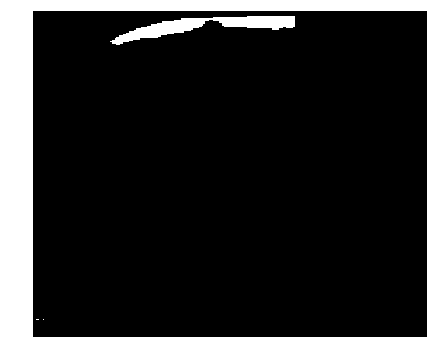

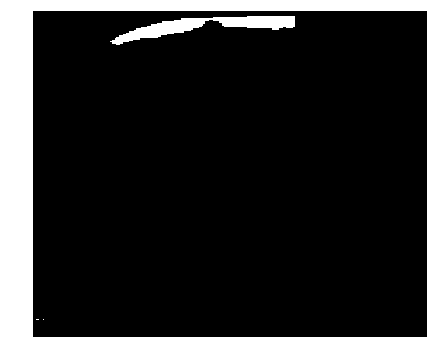

In [62]:
show(slice_i==2)

In [67]:
import pandas as pd

In [70]:
y2, x2 = np.where(slice_i==2)
df = pd.DataFrame()
df['y'] = y2
df['x'] = x2

In [75]:
df['y'].min()

4

In [81]:
gorny_kontur = df.groupby('x').min().reset_index()

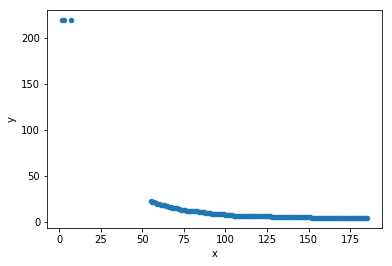

In [82]:
gorny_kontur.plot(kind='scatter', x='x', y='y')

In [83]:
dolny_kontur = df.groupby('x').max().reset_index()

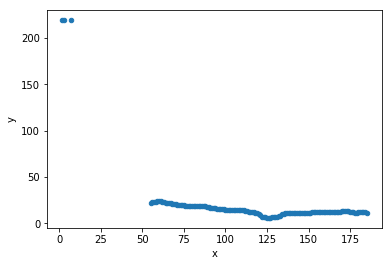

In [84]:
dolny_kontur.plot(kind='scatter', x='x', y='y')

In [85]:
kontur = pd.concat([gorny_kontur, dolny_kontur])

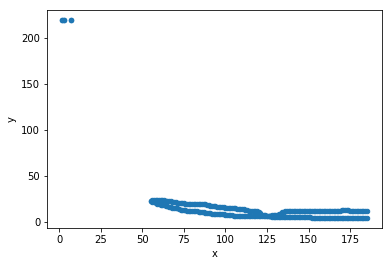

In [86]:
kontur.plot(kind='scatter', x='x', y='y')

### powiedzmy ze wyglada to prawie ok;
oprocz tego ze kontur sie nie zamyka ale to wezmiemy dla kazdego x wypelnimy y pomiedzy
konturami dwojka
(nalozymy taka maske albo cus)

### to teraz wybierzmy sobie dolny kontur i znajdzmy dolny kontur dla kazdego skrawka w plaszczyznie koronalnej


100%|██████████| 405/405 [00:03<00:00, 123.73it/s]


In [ ]:
def prawidlowa_interpolacja_2D(img_mask_data, step=2):
    x_max, y_max, z_max = img_mask_data.shape
    grid_x, grid_y, grid_z = np.mgrid[0:x_max:1, 0:y_max:1,0:z_max:1]
    #points = np.random.rand(1000, 2)
    point_list = []
    for i in tqdm(range(x_max)):
        for j in range(0,y_max,2):
            for k in range(img_mask_data.shape[2]):
                point_list.append([i,j,k])
    points = np.array(point_list)
    values = img_mask_data[points[:,0],points[:,1],points[:,2]]
    grid_z2 = griddata(points, values, (grid_x, grid_y, grid_z), method='linear')
    #values = img_mask_data[points]
    #img_mask_data
    #del point_list
    grid_num = np.nan_to_num(grid_z2)
    show(grid_num[:,1,:])
    return grid_num

In [ ]:
def func(x, z):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*z**2)**2

In [140]:
def prawidlowa_interpolacja_2D():
    dolne_kontury = []
for z in tqdm(range(img_mask_data.shape[1])):
    coronal_slice = img_mask_data[:,z,:]
    y2, x2 = np.where(coronal_slice==2)
    df = pd.DataFrame()
    df['y'] = y2
    df['x'] = x2
    dolny_kontur = df.groupby('x').max().reset_index()
    gorny_kontur = df.groupby('x').min().reset_index()
    dolny_kontur['z'] = z
    dolne_kontury.append(dolny_kontur)
# teraz tak; dolny kontur:
#    dla dolnego kontura y jest funkcja x i zeta (ktory jest druga wspolrzedna niepostrzezenie)
# no i teraz z jest co piaty tylko
# i musimy znalezc dla reszty zetow wartosci
dolne_kontury = pd.concat(dolne_kontury)
x_max = dolny_kontur['x'].max()
z_max = img_mask_data.shape[1]
grid_x, grid_z = np.mgrid[50:x_max:1, 0:z_max:1]
points = dolne_kontury[['x','z']].values[::2]
values = dolne_kontury['y'].values[::2]
grid_z2 = griddata(points, values, (grid_x, grid_z), method='linear')
pd.DataFrame(grid_z2[:,93],columns=['y']).reset_index().plot()
    return

In [141]:
grid_x.max()

184

In [142]:
points = np.random.rand(1000, 2)

In [143]:
point_list = []
for i in tqdm(range(x_max)):
    for j in range(0, z_max, 2):
        point_list.append([i,j])
points = np.array(point_list)

100%|██████████| 185/185 [00:00<00:00, 2379.30it/s]


In [144]:
values = img_mask_data[points[:,0],points[:,1],points[:,2]]

IndexError: index 2 is out of bounds for axis 1 with size 2

### trzeba sie zastanowic nad inputem
Najwygodniej zeby inputem byl array w ktorym po prostu w nieokreslonych
komorkach bylo None

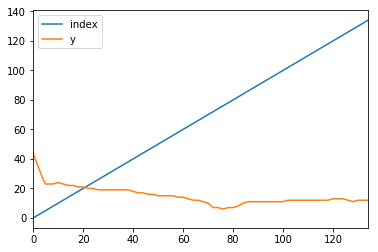

In [146]:

#trzeba zmienic grida zeby sie zaczynal tak od 25

In [114]:
pd.DataFrame(points, columns=['x','z'])

,x,z
0,0,0
1,0,2
2,0,4
3,0,6
4,0,8
5,0,10
6,0,12
7,0,14
8,0,16
9,0,18
